In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb

In [29]:
trans = pd.read_csv('Dataset/transactions.csv')
trans_each_inID = trans.groupby(['Invoice ID', 'Customer ID', 'Date','Store ID','Employee ID','Currency','Transaction Type']).agg({
    'Product ID': list, 
    'Line Total': 'sum'
}).reset_index()

In [30]:
#Take care data

trans_each_inID['Date'] = pd.to_datetime(trans_each_inID['Date'])

exchange_rates = pd.DataFrame({
    "Currency": ["USD", "CNY", "GBP", "EUR"],  
    "to_USD": [1.00, 0.14, 1.33, 1.16]
})
trans_each_inID = trans_each_inID.merge(exchange_rates, on='Currency', how='left')
trans_each_inID['to_USD'] = trans_each_inID['to_USD'].fillna(1.0)
trans_each_inID['Line Total'] = trans_each_inID['Line Total'] * trans_each_inID['to_USD']

# Get daily sales data
daily_sales = (
    trans_each_inID.groupby(trans_each_inID["Date"].dt.date)["Line Total"]
    .sum()
    .rename("daily_total_usd")
    .reset_index()
)
daily_sales["Date"] = pd.to_datetime(daily_sales["Date"])
daily_sales.head()

,Date,daily_total_usd
0,2023-01-01,759856.5580
1,2023-01-02,177565.8705
2,2023-01-03,158566.6598
3,2023-01-04,164006.1005
4,2023-01-05,157792.9851


In [39]:
# Feature Engineering cho Time Series Forecasting
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error



import warnings
warnings.filterwarnings('ignore')

# Sắp xếp theo ngày
daily_sales = daily_sales.sort_values('Date').reset_index(drop=True)

# Tạo các features từ Date
daily_sales['year'] = daily_sales['Date'].dt.year
daily_sales['month'] = daily_sales['Date'].dt.month
daily_sales['day'] = daily_sales['Date'].dt.day
daily_sales['day_of_week'] = daily_sales['Date'].dt.dayofweek  # 0=Monday, 6=Sunday
daily_sales['day_of_year'] = daily_sales['Date'].dt.dayofyear
daily_sales['week_of_year'] = daily_sales['Date'].dt.isocalendar().week
daily_sales['quarter'] = daily_sales['Date'].dt.quarter
daily_sales['is_weekend'] = (daily_sales['day_of_week'] >= 5).astype(int)

# is_holiday (đơn giản hoá theo ngày cố định trong năm)
holiday_md = {
    (1, 1),   # New Year
    (2, 14),  # Valentine (ví dụ)
    (4, 30),  # VN: Giải phóng
    (5, 1),   # Labor Day
    (9, 2),   # VN: Quốc khánh
    (12, 24), # Christmas Eve
    (12, 25), # Christmas
    (12, 31)  # New Year's Eve
}
daily_sales['is_holiday'] = daily_sales['Date'].apply(lambda d: int((d.month, d.day) in holiday_md))

# Lag features (giá trị trong quá khứ)
for lag in [1, 2, 3, 7, 14, 28, 30]:
    daily_sales[f'lag_{lag}'] = daily_sales['daily_total_usd'].shift(lag)

# Rolling statistics (thống kê trượt)
for window in [7, 14, 30]:
    daily_sales[f'rolling_mean_{window}'] = daily_sales['daily_total_usd'].rolling(window=window).mean()
    daily_sales[f'rolling_std_{window}'] = daily_sales['daily_total_usd'].rolling(window=window).std()
    daily_sales[f'rolling_min_{window}'] = daily_sales['daily_total_usd'].rolling(window=window).min()
    daily_sales[f'rolling_max_{window}'] = daily_sales['daily_total_usd'].rolling(window=window, min_periods=1).max()
# Bỏ rolling_mean_7 theo yêu cầu cắt bớt trùng lặp
if 'rolling_mean_7' in daily_sales.columns:
    daily_sales.drop(columns=['rolling_mean_7'], inplace=True)
# Exponential moving average
for span in [7, 14, 30]:
    daily_sales[f'ema_{span}'] = daily_sales['daily_total_usd'].ewm(span=span, adjust=False).mean()

# Trend features
daily_sales['diff_1'] = daily_sales['daily_total_usd'].diff(1)
# Bỏ diff_7 theo yêu cầu
# daily_sales['diff_7'] = daily_sales['daily_total_usd'].diff(7)
daily_sales['pct_change_1'] = daily_sales['daily_total_usd'].pct_change(1)
daily_sales['pct_change_7'] = daily_sales['daily_total_usd'].pct_change(7)

# Cyclical encoding cho month và day_of_week (sin/cos transformation)
daily_sales['month_sin'] = np.sin(2 * np.pi * daily_sales['month'] / 12)
daily_sales['month_cos'] = np.cos(2 * np.pi * daily_sales['month'] / 12)
daily_sales['day_of_week_sin'] = np.sin(2 * np.pi * daily_sales['day_of_week'] / 7)
daily_sales['day_of_week_cos'] = np.cos(2 * np.pi * daily_sales['day_of_week'] / 7)
daily_sales['day_of_year_sin'] = np.sin(2 * np.pi * daily_sales['day_of_year'] / 365)
daily_sales['day_of_year_cos'] = np.cos(2 * np.pi * daily_sales['day_of_year'] / 365)

print(f"Tổng số features: {len(daily_sales.columns)}")
print(f"Shape của dataset: {daily_sales.shape}")
daily_sales.head()


Tổng số features: 41
Shape của dataset: (808, 41)


,Date,daily_total_usd,year,month,day,day_of_week,day_of_year,week_of_year,quarter,is_weekend,...,ema_30,diff_1,pct_change_1,pct_change_7,month_sin,month_cos,day_of_week_sin,day_of_week_cos,day_of_year_sin,day_of_year_cos
0,2023-01-01,759856.5580,2023,1,1,6,1,52,1,1,...,759856.558000,NaN,NaN,NaN,0.5,0.866025,-0.781831,0.623490,0.017213,0.999852
1,2023-01-02,177565.8705,2023,1,2,0,2,1,1,0,...,722289.416871,-582290.6875,-0.766317,NaN,0.5,0.866025,0.000000,1.000000,0.034422,0.999407
2,2023-01-03,158566.6598,2023,1,3,1,3,1,1,0,...,685920.206737,-18999.2107,-0.106998,NaN,0.5,0.866025,0.781831,0.623490,0.051620,0.998667
3,2023-01-04,164006.1005,2023,1,4,2,4,1,1,0,...,652248.328916,5439.4407,0.034304,NaN,0.5,0.866025,0.974928,-0.222521,0.068802,0.997630
4,2023-01-05,157792.9851,2023,1,5,3,5,1,1,0,...,620347.984153,-6213.1154,-0.037883,NaN,0.5,0.866025,0.433884,-0.900969,0.085965,0.996298


In [40]:
# Chuẩn bị dữ liệu cho training
# Loại bỏ các dòng có NaN (do lag và rolling features)
df_model = daily_sales.dropna().copy()

# Chọn features để train (loại bỏ Date và target)
feature_cols = [col for col in df_model.columns if col not in ['Date', 'daily_total_usd']]
X = df_model[feature_cols]
y = df_model['daily_total_usd']

print(f"Số lượng features: {len(feature_cols)}")
print(f"Số lượng samples sau khi dropna: {len(df_model)}")
print(f"\nCác features được sử dụng:")
for i, col in enumerate(feature_cols, 1):
    print(f"{i}. {col}")


Số lượng features: 39
Số lượng samples sau khi dropna: 778

Các features được sử dụng:
1. year
2. month
3. day
4. day_of_week
5. day_of_year
6. week_of_year
7. quarter
8. is_weekend
9. is_holiday
10. lag_1
11. lag_2
12. lag_3
13. lag_7
14. lag_14
15. lag_28
16. lag_30
17. rolling_std_7
18. rolling_min_7
19. rolling_max_7
20. rolling_mean_14
21. rolling_std_14
22. rolling_min_14
23. rolling_max_14
24. rolling_mean_30
25. rolling_std_30
26. rolling_min_30
27. rolling_max_30
28. ema_7
29. ema_14
30. ema_30
31. diff_1
32. pct_change_1
33. pct_change_7
34. month_sin
35. month_cos
36. day_of_week_sin
37. day_of_week_cos
38. day_of_year_sin
39. day_of_year_cos


In [42]:
# Chia train/val/test set (70/20/10) theo thời gian
n = len(df_model)
train_end = int(n * 0.7)
val_end = int(n * 0.9)

X_train = X.iloc[:train_end]
y_train = y.iloc[:train_end]

X_val = X.iloc[train_end:val_end]
y_val = y.iloc[train_end:val_end]

X_test = X.iloc[val_end:]
y_test = y.iloc[val_end:]

print(f"Train set: {len(X_train)} samples (từ {df_model.iloc[0]['Date'].date()} đến {df_model.iloc[train_end-1]['Date'].date()})")
print(f"Validation set: {len(X_val)} samples (từ {df_model.iloc[train_end]['Date'].date()} đến {df_model.iloc[val_end-1]['Date'].date()})")
print(f"Test set: {len(X_test)} samples (từ {df_model.iloc[val_end]['Date'].date()} đến {df_model.iloc[-1]['Date'].date()})")


Train set: 544 samples (từ 2023-01-31 đến 2024-07-27)
Validation set: 156 samples (từ 2024-07-28 đến 2024-12-30)
Test set: 78 samples (từ 2024-12-31 đến 2025-03-18)


In [47]:
# Tạo LightGBM datase
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

# Thiết lập parameters cho LightGBM
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42
}
# Train model
print("Đang train mô hình LightGBM...")
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'val'],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=True),
        lgb.log_evaluation(period=100)
    ]
)

print("\nTraining hoàn tất!")


Đang train mô hình LightGBM...
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 50621.2	val's rmse: 121799
[200]	train's rmse: 36198.9	val's rmse: 112779
[300]	train's rmse: 26456.8	val's rmse: 105697
[400]	train's rmse: 20959.7	val's rmse: 103006
[500]	train's rmse: 17462.9	val's rmse: 101340
Early stopping, best iteration is:
[505]	train's rmse: 17269.5	val's rmse: 100784

Training hoàn tất!


In [48]:
# Dự đoán
y_train_pred = model.predict(X_train, num_iteration=model.best_iteration)
y_val_pred = model.predict(X_val, num_iteration=model.best_iteration)
y_test_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Tính các metrics
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

val_mae = mean_absolute_error(y_val, y_val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)

test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print("=" * 60)
print("KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH")
print("=" * 60)
print(f"\nTRAIN SET:")
print(f"  MAE (Mean Absolute Error):  {train_mae:,.2f} USD")
print(f"  RMSE (Root Mean Squared Error): {train_rmse:,.2f} USD")
print(f"  R² Score: {train_r2:.4f}")

print(f"\nVALIDATION SET:")
print(f"  MAE (Mean Absolute Error):  {val_mae:,.2f} USD")
print(f"  RMSE (Root Mean Squared Error): {val_rmse:,.2f} USD")
print(f"  R² Score: {val_r2:.4f}")

print(f"\nTEST SET:")
print(f"  MAE (Mean Absolute Error):  {test_mae:,.2f} USD")
print(f"  RMSE (Root Mean Squared Error): {test_rmse:,.2f} USD")
print(f"  R² Score: {test_r2:.4f}")

print(f"\nMAPE (Mean Absolute Percentage Error) - Test: {(np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100):.2f}%")


KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH

TRAIN SET:
  MAE (Mean Absolute Error):  5,153.45 USD
  RMSE (Root Mean Squared Error): 17,269.50 USD
  R² Score: 0.9929

VALIDATION SET:
  MAE (Mean Absolute Error):  56,449.86 USD
  RMSE (Root Mean Squared Error): 100,784.47 USD
  R² Score: 0.8923

TEST SET:
  MAE (Mean Absolute Error):  17,332.02 USD
  RMSE (Root Mean Squared Error): 35,377.89 USD
  R² Score: 0.9472

MAPE (Mean Absolute Percentage Error) - Test: 6.79%


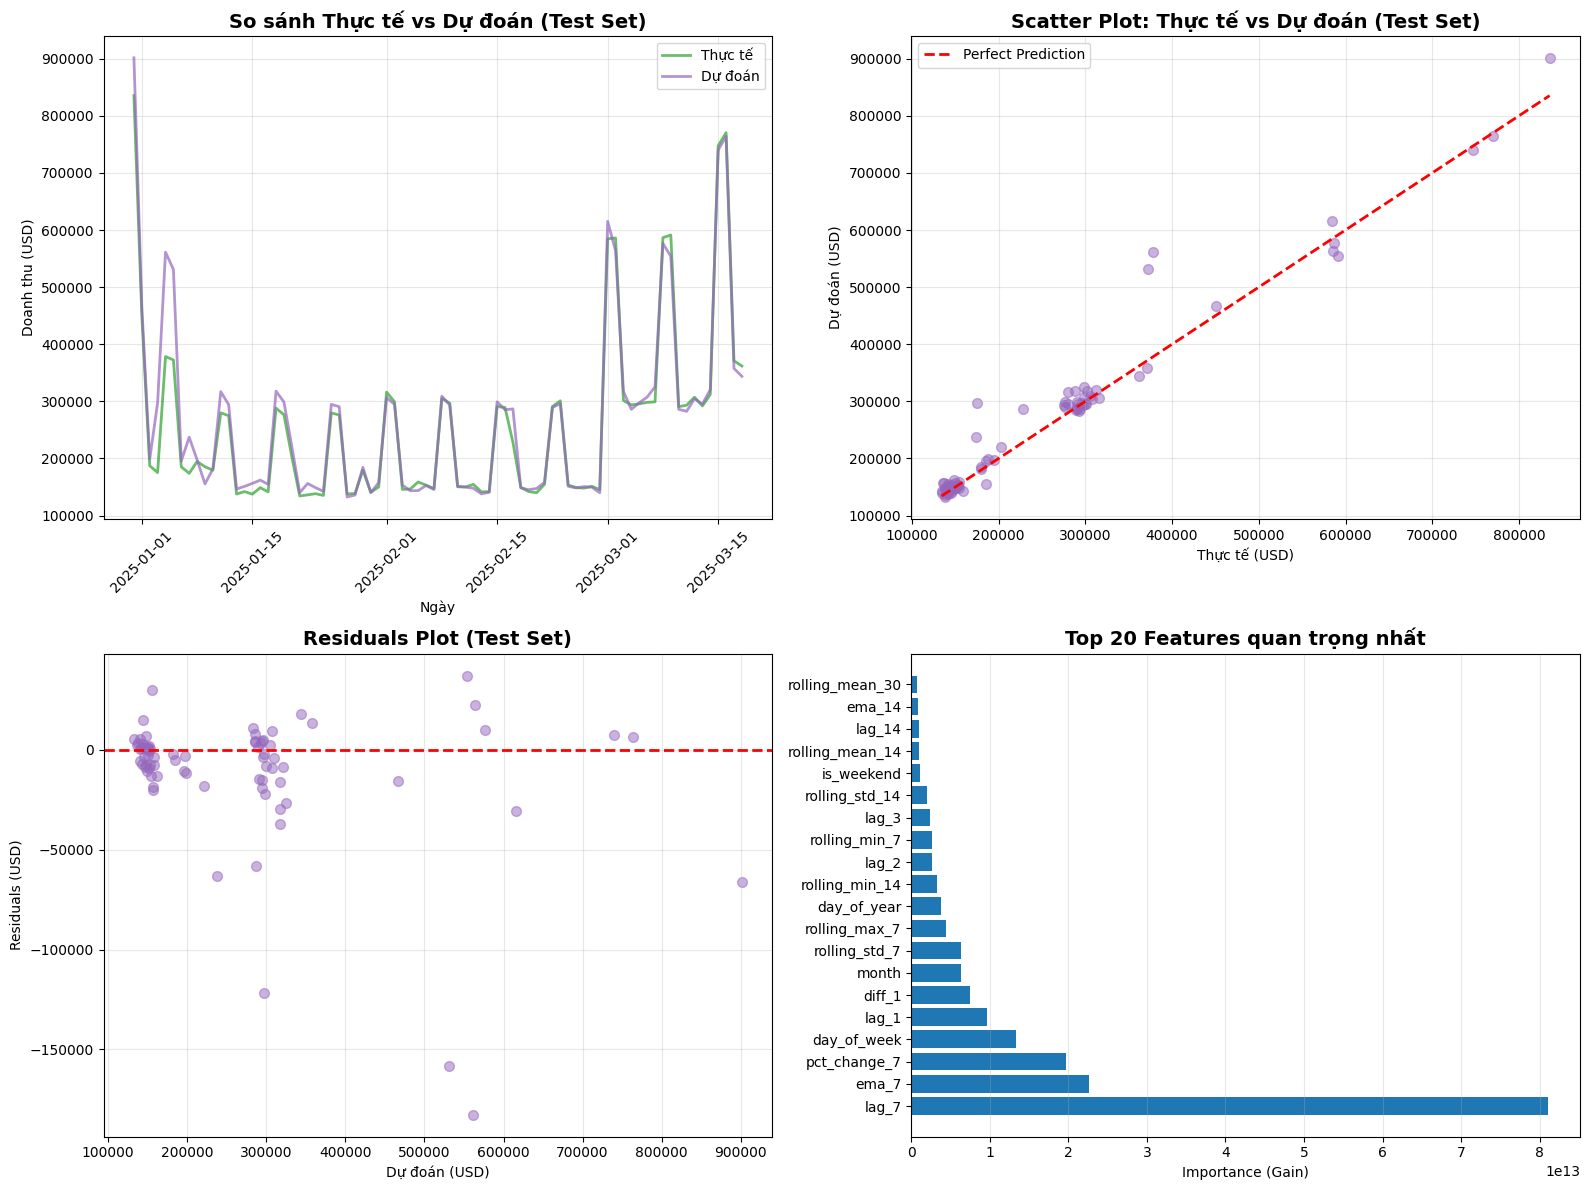

In [49]:
# Visualize kết quả
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. So sánh thực tế vs dự đoán trên test set
axes[0, 0].plot(df_model.iloc[val_end:]['Date'], y_test.values, label='Thực tế', linewidth=2, alpha=0.7, color='tab:green')
axes[0, 0].plot(df_model.iloc[val_end:]['Date'], y_test_pred, label='Dự đoán', linewidth=2, alpha=0.7, color='tab:purple')
axes[0, 0].set_title('So sánh Thực tế vs Dự đoán (Test Set)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Ngày')
axes[0, 0].set_ylabel('Doanh thu (USD)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Scatter plot: Thực tế vs Dự đoán
axes[0, 1].scatter(y_test, y_test_pred, alpha=0.5, s=50, color='tab:purple')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0, 1].set_xlabel('Thực tế (USD)')
axes[0, 1].set_ylabel('Dự đoán (USD)')
axes[0, 1].set_title('Scatter Plot: Thực tế vs Dự đoán (Test Set)', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Residuals plot
residuals = y_test - y_test_pred
axes[1, 0].scatter(y_test_pred, residuals, alpha=0.5, s=50, color='tab:purple')
axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Dự đoán (USD)')
axes[1, 0].set_ylabel('Residuals (USD)')
axes[1, 0].set_title('Residuals Plot (Test Set)', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False).head(20)

axes[1, 1].barh(range(len(feature_importance)), feature_importance['importance'])
axes[1, 1].set_yticks(range(len(feature_importance)))
axes[1, 1].set_yticklabels(feature_importance['feature'])
axes[1, 1].set_xlabel('Importance (Gain)')
axes[1, 1].set_title('Top 20 Features quan trọng nhất', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


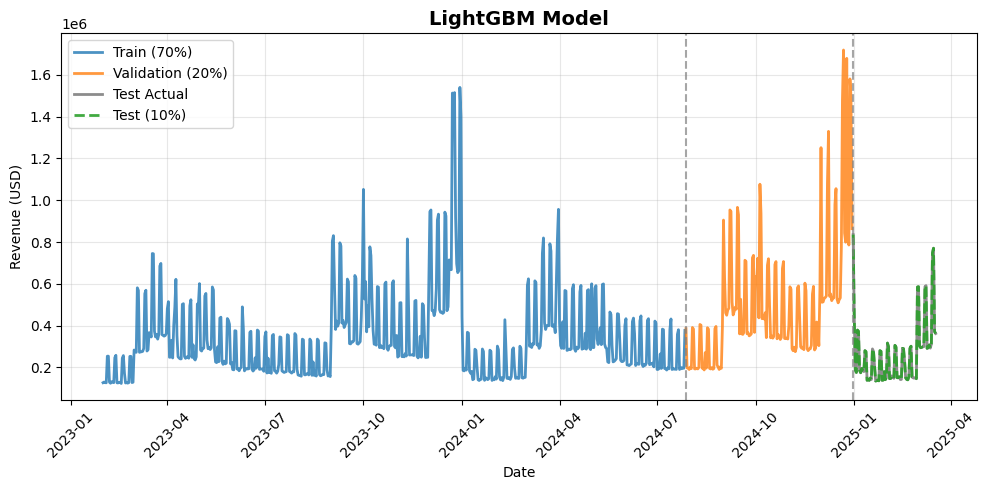

In [50]:
# Biểu đồ phân đoạn theo tập Train / Validation / Test (màu khác nhau)
plt.figure(figsize=(10, 5))

# Train (70%)
plt.plot(
    df_model['Date'].iloc[:train_end],
    df_model['daily_total_usd'].iloc[:train_end],
    label='Train (70%)',
    color='tab:blue', linewidth=2, alpha=0.8
)

# Validation (20%)
plt.plot(
    df_model['Date'].iloc[train_end:val_end],
    df_model['daily_total_usd'].iloc[train_end:val_end],
    label='Validation (20%)',
    color='tab:orange', linewidth=2, alpha=0.8
)

# Đường màu xám hiển thị dữ liệu thực tế của tập Test
plt.plot(
    df_model['Date'].iloc[val_end:],
    y_test.values,          # dữ liệu thực tế Test
    label='Test Actual',
    color='gray', linewidth=2, alpha=0.9
)

# Test (10%)
plt.plot(
    df_model['Date'].iloc[val_end:],
    df_model['daily_total_usd'].iloc[val_end:],
    label='Test (10%)',
    color='tab:green', linewidth=2, alpha=0.9,
    linestyle='--'
)


# Vạch ranh giới
plt.axvline(df_model['Date'].iloc[train_end], color='gray', linestyle='--', alpha=0.7)
plt.axvline(df_model['Date'].iloc[val_end], color='gray', linestyle='--', alpha=0.7)

plt.title('LightGBM Model', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Revenue (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
